# Χρονοσειρές Lorentz

## 1. Εγκατάσταση βιβλιοθηκών
#### NumPy → ταχύς χειρισμός πινάκων.
#### SciPy → έτοιμοι ολοκληρωτές ODE (π.χ. solve_ivp).
#### Matplotlib → γραφήματα 2-D & 3-D.
#### pandas → ευέλικτο data container (DataFrame).



In [8]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp        # εναλλακτικά: from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pyrcn.echo_state_network import ESNRegressor
from sklearn.preprocessing import MinMaxScaler

from numpy import array
import math
import csv


## 2. Ορισμός παραμέτρων & εξισώσεων Lorenz
#### εξισώσεις Lorentz:
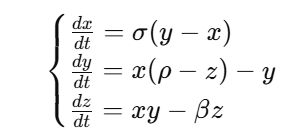

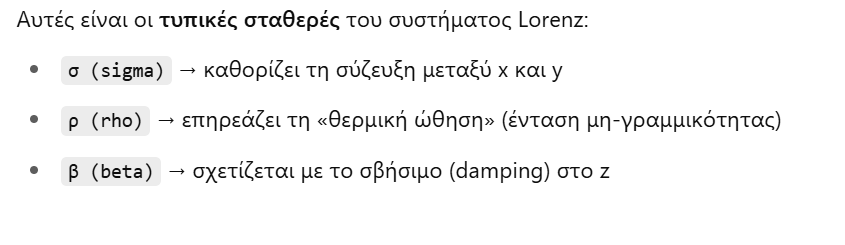


In [9]:
# Παράμετροι
sigma = 10.0          # ένταση «περιστροφικού» όρου (σχετικό με Prandtl)
beta  = 8.0 / 3.0     # γεωμετρικός/αγώγιμος συντελεστής
rho   = 28.0          # «θερμική ώθηση» (Rayleigh number)

# 3.2 Συνάρτηση που δίνει τα παράγωγα
def lorenz(t, state):
    """
    t      : τρέχων χρόνος (float, αλλά δεν χρησιμοποιείται ρητά)
    state  : διάνυσμα [x, y, z] τη χρονική στιγμή t
    return : λίστα [dx/dt, dy/dt, dz/dt]
    """
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


## 3. Ρύθμιση χρονικού πλέγματος & αρχικών συνθηκών

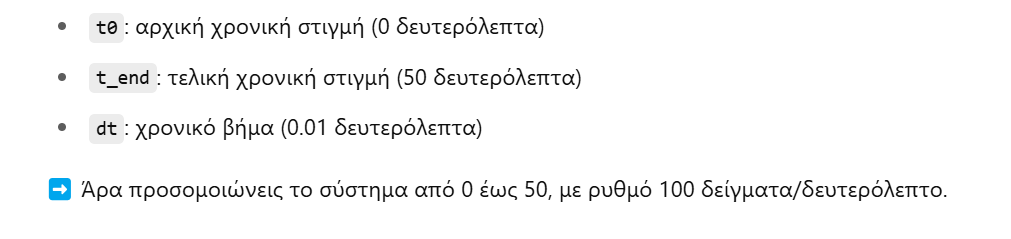

In [10]:
t0, t_end, dt = 0.0, 50.0, 0.01       # από 0 ως 50 "δευτερόλεπτα" με βήμα 0.01
t_eval = np.arange(t0, t_end + dt, dt)  # σημείο-σημείο εξαγωγής

initial_state = [1.0, 1.0, 1.0]       # x0, y0, z0


## 4. Αριθμητική ολοκλήρωση
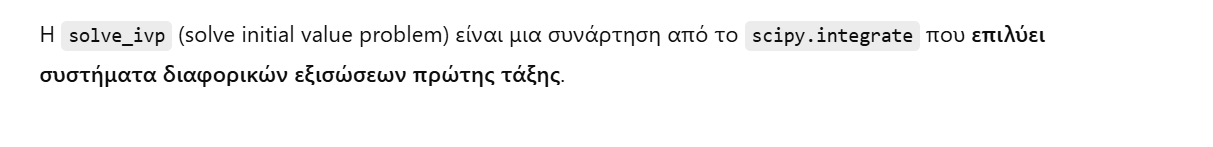


In [11]:
sol = solve_ivp(
    lorenz,                # η συνάρτηση με τα παράγωγα
    (t0, t_end),           # χρονικό διάστημα ολοκλήρωσης
    initial_state,         # αρχικές τιμές
    method="RK45",         # Dormand–Prince 4(5)
    t_eval=t_eval,         # πού θες αποτελέσματα
    rtol=1e-9, atol=1e-12  # έλεγχος σφάλματος
)


In [12]:
t = sol.t
x, y, z = sol.y          # "ξεδιπλώνουμε" τις τρεις χρονοσειρές


## Normalize Lorenz state variables x, y, z into the range [-1, 1]


In [ ]:

# Assume x, y, z are 1-D numpy arrays of the same length
# Stack them into a single (n_steps, 3) array for joint scaling
data = np.column_stack((x, y, z))  # shape: (n_steps, 3)

# Create a MinMaxScaler that maps to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the combined data and transform in one step
data_scaled = scaler.fit_transform(data)

# Unpack the scaled columns back into x, y, z
x_scaled, y_scaled, z_scaled = data_scaled[:, 0], data_scaled[:, 1], data_scaled[:, 2]

# (Optional) Replace original variables with scaled versions for ESN input
x, y, z = x_scaled, y_scaled, z_scaled


In [13]:
data = np.column_stack((x, y, z))
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)
x, y, z = data_scaled[:, 0], data_scaled[:, 1], data_scaled[:, 2]

## 5. Μετατροπή σε DataFrame



In [14]:
df = (
    pd.DataFrame({"t": t, "x": x, "y": y, "z": z})
      .set_index("t")        # χρόνος ως index ⇒ έτοιμο για resample/rolling
)
df.head()                    # δείχνει τις 5 πρώτες γραμμές


,x,y,z
t,,,
0.00,-0.007026,-0.046285,-0.998367
0.01,-0.006344,-0.035898,-0.999012
0.02,-0.004377,-0.025346,-0.999515
0.03,-0.001208,-0.014384,-0.999854
0.04,0.003115,-0.002787,-1.000000


## 6. Οπτικοποίηση χρονοσειρών


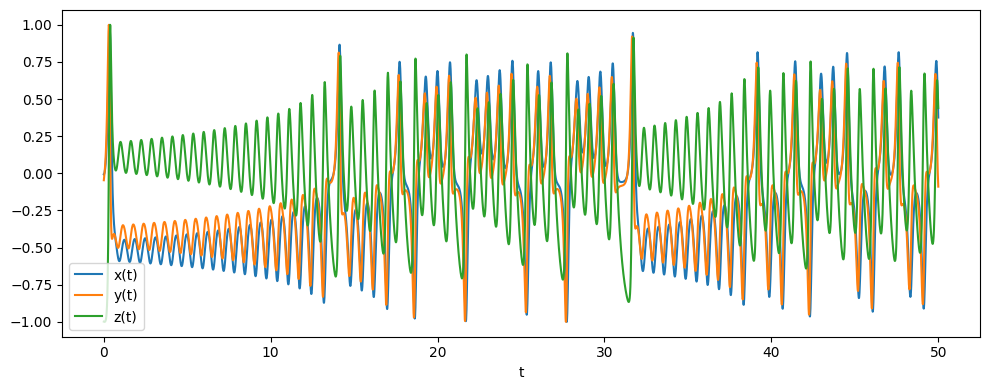

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["x"], label="x(t)")
plt.plot(df.index, df["y"], label="y(t)")
plt.plot(df.index, df["z"], label="z(t)")
plt.xlabel("t"), plt.legend(), plt.tight_layout()
plt.show()


## Ελκυστής («πεταλούδα»)
### Δημιουργεί τρισδιάστατο διάγραμμα της τροχιάς του συστήματος Lorenz στον χώρο των μεταβλητών (x, y, z) — δηλαδή οπτικοποιεί το διάσημο “Lorenz attractor”.

<function matplotlib.pyplot.show(close=None, block=None)>

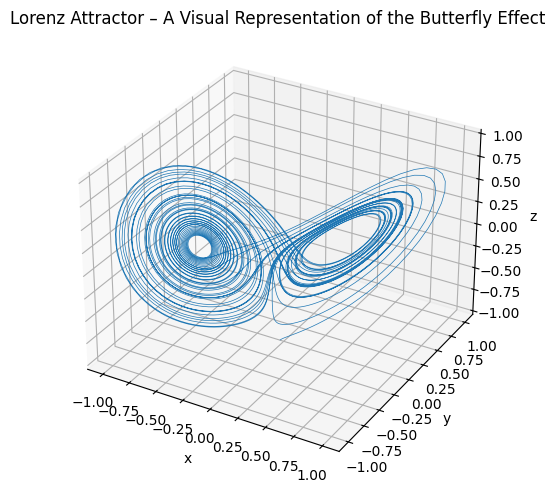

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # μόνο για να ενεργοποιηθεί το 3-D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, linewidth=0.5)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")
ax.set_title("Lorenz Attractor – A Visual Representation of the Butterfly Effect")
plt.tight_layout(); plt.show



# Δομή Sliding Window Multi-Step Forecasting
## Σκοπός: Δημιουργείς πολλά training samples από τη χρονοσειρά x(t)
#         Για κάθε sample: Input: 50 τιμές (ιστορικό) , Target: οι επόμενες 10 τιμές



### X_ins: τα παραθυρικά inputs (ιστορικό 50 τιμών)

### y_targets: τα αντίστοιχα multi-step targets (10 τιμές)

### prices: η τελευταία τιμή κάθε εισόδου (χρήσιμη αν κάνεις normalization)




In [17]:
y_targets = list()     # τα αντίστοιχα multi-step targets (10 τιμές)
X_ins = list()         # τα inputs (ιστορικό 50 τιμών) 
prices = list()        # η τελευταία τιμή κάθε εισόδου (χρήσιμη αν κάνεις normalization)



# Παράμετροι
input_window = 50
forecast_horizon = 10

for i in range(len(df)):
    end = i + input_window + forecast_horizon
    if end > len(df):
        break  # Αν δεν έχουμε αρκετά δεδομένα για full παράθυρο

    # Ολόκληρο το παράθυρο: input + forecast
    seq_full = df['x'].iloc[i:end].reset_index(drop=True)

    # Είσοδος: οι πρώτες 50 τιμές
    seq_input = seq_full[:input_window]
    X_ins.append(np.round(np.array(seq_input), 5))

    # Στόχος: οι επόμενες 10 τιμές
    seq_target = seq_full[input_window:]  # δηλαδή θέσεις 50–59
    y_targets.append(np.round(np.array(seq_target), 5))

    # Για normalization (προαιρετικά)
    prices.append(seq_input.iloc[-1])

X = np.array(X_ins)           # shape = (n_samples, 50)
Y = np.array(y_targets)       # shape = (n_samples, 10)


### Αυτό σχεδιάζει το 1ό παράθυρο εισόδου (δηλαδή το 50-βηματικό ιστορικό τιμών από t=0 έως t=0.49), 
### ώστε να μπορείτε να δείτε πώς μοιάζει ένα τυπικό δείγμα εκπαίδευσης.

In [18]:
X[0]


array([-0.00703, -0.00634, -0.00438, -0.00121,  0.00312,  0.00858,
        0.0152 ,  0.02302,  0.03211,  0.04256,  0.05447,  0.06799,
        0.08326,  0.10047,  0.11981,  0.1415 ,  0.16578,  0.19289,
        0.22309,  0.25664,  0.29378,  0.33473,  0.37964,  0.42858,
        0.48146,  0.53802,  0.59773,  0.65971,  0.72268,  0.78493,
        0.84422,  0.89795,  0.94318,  0.97696,  0.9966 ,  1.     ,
        0.98603,  0.95469,  0.90712,  0.84548,  0.77266,  0.69187,
        0.60633,  0.51899,  0.43235,  0.34838,  0.26852,  0.19373,
        0.12455,  0.06123])

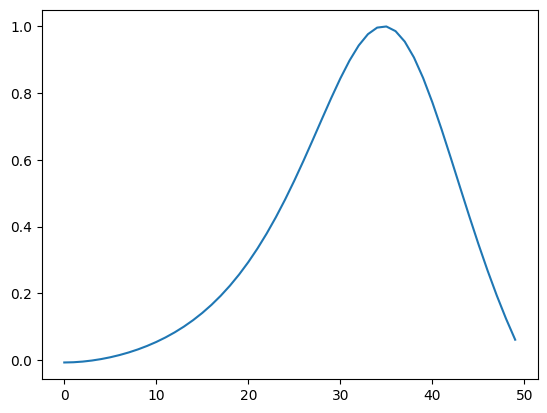

In [19]:
plt.plot(X[0])

## Το παράθυρο πρόβλεψεις με τις 10 τιμές στον μέλον

In [20]:
Y[0]

array([ 0.00373, -0.04811, -0.09462, -0.13618, -0.1732 , -0.20611,
       -0.23535, -0.26134, -0.28448, -0.30512])

## Διαχωρισμός σε training set & test set
### Το πρώτο 80% θα χρησιμοποιηθεί για το training set


In [21]:
#Διαχωρισμός σε training set και test set
ts = round(len(X)*0.8)
#inputs
# το πρώτο 80% train set και το υπόλοιπο test set
train_set = X[:ts]
test_set = X[ts:]
#outputs
#
y_train = Y[:ts]
y_test = Y[ts:]

# ο λόγος που χρησιμοποιούμε numpy vectors είναι γιατί πολλές βιβλιοήκες ML τα χρησιμοποιούν
y_train = np.array(y_train)
y_test = np.array(y_test)

## Εισάγουμε κάποιες βιβλιοθήκες
### 1) from sklearn.linear_model import Ridge
### Η παλινδρόμηση Ridge θα είναι το read‐out layer: ένα γραμμικό μοντέλο με L₂ κανονικοποίηση,
### που μαθαίνει να χαρτογραφεί τις καταστάσεις του reservoir στις τιμές‐στόχους.
### 2) from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
### Το GridSearchCV εκτελεί εξαντλητική αναζήτηση σε πλέγμα υπερπαραμέτρων
### (π.χ. διαφορετικά spectral_radius, leakage κ.λπ.), χρησιμοποιώντας cross‐validation
### για να επιλέξει τον καλύτερο συνδυασμό.
### Το TimeSeriesSplit είναι καταμεριστής cross‐validation που διατηρεί τη χρονολογική σειρά
### (χωρίς τυχαιοποίηση), παρέχοντας σωστά train/test folds για χρονοσειρές.
### 3) from sklearn.metrics import make_scorer, mean_squared_error
### Το mean_squared_error είναι η συνάρτηση κόστους (loss) που θα ελαχιστοποιήσετε.
### Το make_scorer(mean_squared_error, greater_is_better=False) το “τυλίγει”
### ώστε να μπορεί να περαστεί στο GridSearchCV (απαιτεί αντικείμενο scorer).
### 4) from pyrcn.model_selection import SequentialSearchCV
### Ένας PyRCN‐specific orchestrator που εκτελεί διαδοχικά βήματα tuning
### (π.χ. πρώτα input_scaling, μετά spectral_radius κ.λπ.), σταθεροποιώντας 
### κάθε φορά τις καλύτερες παραμέτρους.
### 5) from pyrcn.metrics import mean_squared_error
### Η δική του έκδοση του MSE στο PyRCN (ίδια μαθηματικά αλλά συμβατή με το API).
### 6) from pyrcn.echo_state_network import ESNRegressor
### Η κύρια κλάση που υλοποιεί το Echo State Network για regression.
### Τη δημιουργείτε με τα blocks InputToNode και NodeToNode, συν ένα read‐out (Ridge).
### 7) from pyrcn.base.blocks import InputToNode, NodeToNode
### Το InputToNode καθορίζει πώς οι είσοδοι τροφοδοτούνται (και κλιμακώνονται)
### σε κάθε νευρώνα του reservoir.
### Το NodeToNode καθορίζει τις εσωτερικές επαναληπτικές συνδέσεις
### (μέγεθος, spectral radius, leakage, sparsity κ.λπ.).
### 8) from matplotlib import pyplot as plt
### Βασική βιβλιοθήκη σχεδιασμού γραφημάτων για οπτικοποίηση:
### καμπύλες κόστους, προβλέψεις vs πραγματικά, RMSE vs υπερπαράμετροι κ.λπ.


In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from pyrcn.model_selection import SequentialSearchCV
from pyrcn.metrics import mean_squared_error
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.metrics import make_scorer,mean_squared_error

from matplotlib import pyplot as plt

## Φτιαχνουμε μία συνάρτηση που θα υπολογίζει την ελάχιστη τιμή μέσα σε μία λίστα , αυτό θα μας βοηθήσει να ΄βρίσκουμε το ελάχιστο rmse  

In [23]:
def find_min_with_index(lst):
    if not lst:
        raise ValueError("Η λίστα είναι κενή")

    minimum = lst[0]
    min_index = 0

    for i in range(1, len(lst)):  # 👈 i goes from 1 to len(lst) - 1
        if lst[i] < minimum:
            minimum = lst[i]
            min_index = i
    return minimum, min_index


# Βήμα 1: Αρχική ρύθμιση και Grid Search του 
## i) Ορίζει ένα Echo State Network (ESN) με κάποιες σταθερές βασικές παραμέτρους
## ii) Ορίζει και ένα σετ υπερπαραμέτρων (όπως leakage, spectral_radius, input_scaling) που θες να βελτιστοποιήσεις
## iii) Χρησιμοποιεί Grid Search (μέσω του SequentialSearchCV) για να βρει το βέλτιστο συνδυασμό παραμέτρων
## iv) Κάνει εκπαίδευση με cross-validation στο training set
## v) Τέλος, εμφανίζει το καλύτερο μοντέλο που βρέθηκε

In [24]:
# Απενεργοποιούμε όλες τις προειδοποιήσεις για καθαρό output
import warnings
warnings.filterwarnings('ignore')

# initially_fixed_params: λεξικό με σταθερές παραμέτρους του ESN για αυτό το βήμα.
#   hidden_layer_size=400      : αριθμός κόμβων στο reservoir
#   input_activation='identity': χωρίς μη γραμμικό μετασχηματισμό εισόδου
#   reservoir_activation='tanh': ενεργοποίηση μέσα στο reservoir
#   bidirectional=False        : καμία οπισθοδρόμηση (μόνο προς τα εμπρός)
#   alpha=1e-5                 : δύναμη κανονικοποίησης Ridge για το read-out
#   k_rec=10                   : κάθε κόμβος έχει 10 επαναληπτικές συνδέσεις
#   random_state=42            : αναπαραγωγιμότητα τυχαίων βαρών
#   requires_sequence=False    : δεν απαιτείται η ολόκληρη ακολουθία κατά το fit
initially_fixed_params = {
    'hidden_layer_size': 400,
    'input_activation': 'identity',
    'reservoir_activation': 'tanh',
    'bidirectional': False,
    'alpha': 1e-5,
    'k_rec': 10,
    'random_state': 42,
    'requires_sequence': False
}

# step1_esn_params: grid υπερπαραμέτρων για το πρώτο tuning βήμα
#   → συνολικά 2×2×2 = 8 δυνατότητες
step1_esn_params = {
    'input_scaling':  (0.1, 0.2),
    'spectral_radius': (0.1, 0.2),
    'leakage':         (0.1, 0.2)
}

# Μετατρέπουμε το MSE σε scorer για το GridSearchCV, ώστε να το ελαχιστοποιεί
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)

# Επιπλέον kwargs για το GridSearchCV:
#   verbose=5 : εμφάνιση προόδου ανά fold
#   scoring=scorer : χρήση του MSE scorer
#   n_jobs=1 : σειριακή εκτέλεση (θέσε -1 για παράλληλη)
kwargs_step1 = {
    'verbose': 5,
    'scoring': scorer,
    'n_jobs': 1
}

# Καθορίζουμε το βήμα αναζήτησης:
#   ('βημα', ΜέθοδοςCV, grid παραμέτρων, επιπλέον kwargs)
searches = [
    ('step1', GridSearchCV, step1_esn_params, kwargs_step1)
]

# Δημιουργούμε το ESNRegressor με Ridge read-out και τις σταθερές παραμέτρους
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
esn = ESNRegressor(regressor=Ridge(), **initially_fixed_params)

# Εκτελούμε SequentialSearchCV: 
#   1) παίρνει το base ESN
#   2) τρέχει το 'step1' grid search (8 συνδυασμοί) με TimeSeriesSplit
#   3) επιλέγει τις βέλτιστες input_scaling, spectral_radius, leakage
from pyrcn.model_selection import SequentialSearchCV
esn_opti = SequentialSearchCV(esn, searches=searches).fit(train_set, y_train)

# Εμφανίζουμε το βελτιστοποιημένο ESN με τις επιλεγμένες παραμέτρους
print(esn_opti)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.011 total time=   0.5s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.053 total time=   0.4s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.005 total time=   0.4s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.009 total time=   0.4s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.1;, score=-0.030 total time=   0.6s
[CV 1/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.176 total time=   0.4s
[CV 2/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.095 total time=   0.3s
[CV 3/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.257 total time=   0.4s
[CV 4/5] END input_scaling=0.1, leakage=0.1, spectral_radius=0.2;, score=-0.061 total time=   0.4s
[CV 5/5] END input_scaling=0.1, leakage=0.1, spec

## Δοκιμάζουμε διάφορες τιμές για το Input Scaling για να βρούμε την βέλτιστη

In [26]:
## Καθορίζουμε την λίστα υποψήφιων input_scaling τιμών
in_scaling = [0.1,0.2,0.3,0.4]

In [27]:
# Δημιουργούμε μια λίστα για να αποθηκεύσουμε τα RMSE για κάθε input_scaling
rmses = list()
# Βρόχος πάνω σε όλες τις τιμές του in_scaling
for i in range(len(in_scaling)):
    in_s = in_scaling[i]  # τρέχουσα τιμή input_scaling

    # Ορίζουμε το μπλοκ που τροφοδοτεί το reservoir με είσοδο

    base_input_to_nodes = InputToNode(
        hidden_layer_size=40,        # πλήθος κόμβων reservoir
        input_activation='identity',  # χωρίς μη γραμμική ενεργοποίηση στην είσοδο
        k_in=1,                       # κάθε είσοδος συνδέεται με κάθε κόμβο
        input_scaling=in_s,           # κλιμάκωση εισόδου
        bias_scaling=0.0              # χωρίς bias
    )
    
     # Ορίζουμε τις επαναληπτικές συνδέσεις του reservoir
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=40, # ίδιο πλήθος κόμβων
        spectral_radius=0.1,   # σταθερή φασματική ακτίνα
        leakage=0.2,           # σταθερός ρυθμός διαρροής
        k_rec=10               # κάθε κόμβος συνδέεται με 10 τυχαίους
    )
     
    # Δημιουργούμε το ESN με Ridge read-out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8),
        n_readout_inits=50  #n_readout_inits=50 πεταει τα πρωτα 50 βηματα για να σταθεροποιηθεί το Reservoir
    )
    
    # Εκπαιδεύουμε το ESN πάνω στο training set
    esn.fit(train_set, y_train)
    
    # Παράγουμε προβλέψεις για το ίδιο training set
    predictions = esn.predict(train_set)
    
    # Υπολογίζουμε το MSE και έπειτα το RMSE
    MSE = mean_squared_error(predictions,y_train)
    rmse = math.sqrt(MSE)
        
    # Εκτυπώνουμε και αποθηκεύουμε το RMSE
    print(rmse)
    rmses.append(rmse)

   

0.015323460602408216
0.01561806897056922
0.015336486436745428
0.018261774382887244


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [28]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Το in_scaling που αντιστοιχεί είναι:", in_scaling[index])

Η ελάχιστη τιμή είναι: 0.015323460602408216
Η θέση της είναι: 0
Το in_scaling που αντιστοιχεί είναι: 0.1


## Φτιάχνουμε ένα διάγραμμα που απεικονίζει πως συμπεριφέρεται το rmse για τις δίαφορες τιμές του input scaling

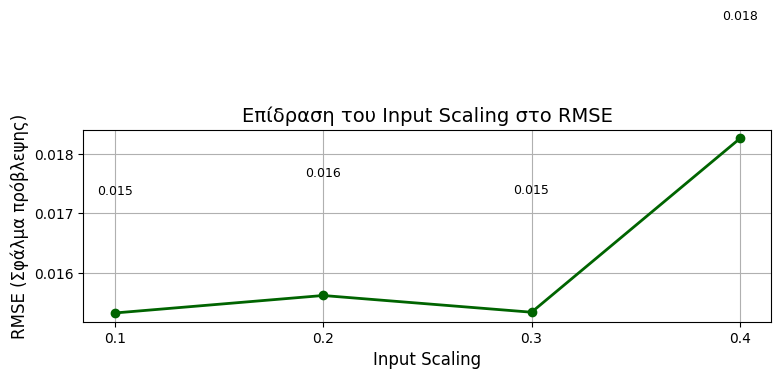

In [29]:
import matplotlib.pyplot as plt

# Δημιουργία γραφήματος
plt.figure(figsize=(8, 5))
plt.plot(in_scaling, rmses, marker='o', linestyle='-', linewidth=2, color='darkgreen')

# Τίτλος και άξονες
plt.title("Επίδραση του Input Scaling στο RMSE", fontsize=14)
plt.xlabel("Input Scaling", fontsize=12)
plt.ylabel("RMSE (Σφάλμα πρόβλεψης)", fontsize=12)

# Προσθήκη τιμών RMSE πάνω από κάθε σημείο
for i, rmse in enumerate(rmses):
    plt.text(in_scaling[i], rmse + 0.002, f"{rmse:.3f}", ha='center', fontsize=9)

# Styling
plt.grid(True)
plt.xticks(in_scaling)
plt.tight_layout()
plt.show()


## Δοκιμάζουμε διάφορες τιμές για τον αριθμό των nodes για να βρούμε την βέλτιστη 


In [30]:
## Καθορίζουμε την λίστα υποψήφιων input_scaling τιμών
nodes = [30,40,50,60,70,80,90,100]

## Θέλουμε να δούμε πώς η απόδοση του ESN (μετρούμενη ως RMSE στο training set) αλλάζει καθώς αλλάζουμε το πλήθος των νευρώνων (nodes) στο εσωτερικό reservoir.

## Λιγότεροι κόμβοι → μικρότερη χωρητικότητα μνήμης, λιγότερο πολύπλοκο μοντέλο

## Περισσότεροι κόμβοι → περισσότερη χωρητικότητα, αλλά και κίνδυνος υπερεκπαίδευσης ή μεγαλύτερο κόστος υπολογισμού

In [31]:

# Εδώ θα αποθηκεύσουμε τα RMSE για κάθε μέγεθος
rmses = []

# Βρόχος πάνω σε κάθε αριθμό κόμβων
for i in range(len(nodes)):
    n_nodes = nodes[i]  # τρέχουσα τιμή hidden_layer_size

    # 1) Ορισμός του μπλοκ εισόδου με n_nodes νευρώνες
    base_input_to_nodes = InputToNode(
        hidden_layer_size=n_nodes,       # πλήθος νευρώνων
        input_activation='identity',     # χωρίς μη-γραμμικότητα στην είσοδο
        k_in=1,                          # πλήρης σύνδεση input → κάθε νευρώνα
        input_scaling=0.1,               # σταθερή κλιμάκωση εισόδου
        bias_scaling=0.0                 # χωρίς bias
    )

    # 2) Ορισμός του μπλοκ επαναληπτικών συνδέσεων (reservoir)
    base_nodes_to_nodes = NodeToNode(
        hidden_layer_size=n_nodes,  # ίδιο πλήθος νευρώνων
        spectral_radius=0.1,        # σταθερή φασματική ακτίνα
        leakage=0.2,                # σταθερή διαρροή μνήμης
        k_rec=10,                   # 10 τυχαίες επαναληπτικές συνδέσεις ανά νευρώνα
              
    )

    # 3) Κατασκευή ESNRegressor με Ridge read‐out
    esn = ESNRegressor(
        input_to_node=base_input_to_nodes,
        node_to_node=base_nodes_to_nodes,
        regressor=Ridge(alpha=1e-8)  # πολύ ελαφριά κανονικοποίηση
    )

    # 4) Εκπαίδευση του ESN στο training set
    esn.fit(train_set, y_train)

    # 5) Πρόβλεψη πάνω στο ίδιο training set
    predictions = esn.predict(train_set)

    # 6) Υπολογισμός MSE και RMSE
    MSE = mean_squared_error(predictions, y_train)
    rmse = math.sqrt(MSE)

    # 7) Εμφάνιση και αποθήκευση του αποτελέσματος
    print(f"n_nodes={n_nodes} → RMSE={rmse:.20f}")
    rmses.append(rmse)


n_nodes=30 → RMSE=0.03399932911602290830
n_nodes=40 → RMSE=0.02094298511804930374
n_nodes=50 → RMSE=0.01463212985071131456
n_nodes=60 → RMSE=0.02648527369978751975
n_nodes=70 → RMSE=0.01266520869875814234
n_nodes=80 → RMSE=0.01416215720201095991
n_nodes=90 → RMSE=0.01148218059770491836
n_nodes=100 → RMSE=0.01046194215748363562


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [32]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Τα nodes που αντιστοιχεί είναι:", nodes[index])

Η ελάχιστη τιμή είναι: 0.010461942157483636
Η θέση της είναι: 7
Τα nodes που αντιστοιχεί είναι: 100


## Γράφημα που δείχνει ποσο μεταβάλεται το σφάλμα με βάση των αριθμών των κόμβων που επιλέχθηκε

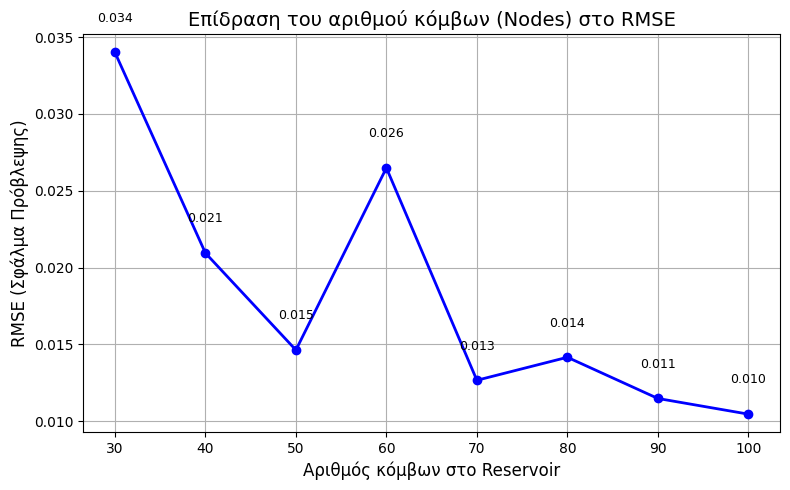

In [33]:


plt.figure(figsize=(8, 5))  # Καθαρό μέγεθος για παρουσίαση
plt.plot(nodes, rmses, marker='o', linestyle='-', linewidth=2, color='blue')

# Προσθήκη τίτλου και αξόνων
plt.title("Επίδραση του αριθμού κόμβων (Nodes) στο RMSE", fontsize=14)
plt.xlabel("Αριθμός κόμβων στο Reservoir", fontsize=12)
plt.ylabel("RMSE (Σφάλμα Πρόβλεψης)", fontsize=12)

# Προαιρετικά: εμφάνιση τιμών RMSE πάνω στα σημεία
for i, rmse in enumerate(rmses):
    plt.text(nodes[i], rmses[i] + 0.002, f"{rmse:.3f}", ha='center', fontsize=9)

plt.grid(True)
plt.xticks(nodes)
plt.tight_layout()
plt.show()


## Σε αυτό το βήμα διαμορφώνουμε την αρχιτεκτονική του Echo State Network, δημιουργώντας: 
### Το μπλοκ εισόδου (InputToNode) που χαρτογραφεί και κλιμακώνει τις εξωτερικές τιμές στο reservoir.
### Το επαναληπτικό μπλοκ (NodeToNode) που ορίζει τη δυναμική και τις εσωτερικές συνδέσεις του reservoir.
### Τον τελικό ESNRegressor, συνδυάζοντας τα δύο blocks με έναν γραμμικό Ridge read-out, έτοιμο να εκπαιδευτεί.

In [34]:
# Ορισμός του μπλοκ εισόδου (Input → Reservoir)
base_input_to_nodes = InputToNode(
    hidden_layer_size=100,   # reservoir με 1000 νευρώνες
    input_activation='identity',  # η είσοδος περνάει αυτούσια, χωρίς μη-γραμμική ενεργοποίηση
    k_in=1,                       # κάθε διάσταση εισόδου συνδέεται με κάθε νευρώνα
    input_scaling=0.1,            # κλιμακώνει την ισχύ του σήματος εισόδου στο 0.4
    bias_scaling=0.0              # δεν προστίθεται επιπλέον bias
)

# Ορισμός του επαναληπτικού μπλοκ (Reservoir → Reservoir)
base_nodes_to_nodes = NodeToNode(
    hidden_layer_size=100,  # ίδια διάσταση reservoir: 1000 νευρώνες
    spectral_radius=0.1,     # φασματική ακτίνα για σταθερότητα της δυναμικής
    leakage=0.2,             # ρυθμός "διαρροής" μνήμης των νευρώνων
    k_rec=10                 # κάθε νευρώνας έχει 10 τυχαίες επαναληπτικές συνδέσεις
)

# Συνδυασμός σε ESNRegressor με Ridge read-out
esn = ESNRegressor(
    input_to_node=base_input_to_nodes,      # το μπλοκ εισόδου που ορίσαμε
    node_to_node=base_nodes_to_nodes,       # το επαναληπτικό μπλοκ
    regressor=Ridge(alpha=1e-8)             # γραμμικός read-out με πολύ ελαφριά κανονικοποίηση
)

## Δημιουργία σετ εισόδων και στόχων για εκπαίδευση ESN βάσει sliding window.


In [35]:
# Λίστα με τα μήκη ιστορικού (μεγέθη παραθύρου) που θα αξιολογηθούν ως είσοδοι για το ESN
windows = [10,15,20,25,30,35,40,45,50,60,70,80,90,100]

In [36]:
def receive_multistep_training_sets(window, horizon):
    """
    Δημιουργεί σύνολο εκπαίδευσης για multi-step forecasting.

    Παράμετροι:
    ----------
    window : int
        Μήκος παραθύρου εισόδου (π.χ. 50)
    horizon : int
        Πλήθος βημάτων μπροστά για πρόβλεψη (π.χ. 10)

    Επιστρέφει:
    ----------
    X_ins : np.ndarray, shape = (n_samples, window)
        Τα παραθυρικά input sequences.

    y_targets : np.ndarray, shape = (n_samples, horizon)
        Τα αντίστοιχα target sequences.

    prices : np.ndarray, shape = (n_samples,)
        Τελευταία τιμή κάθε παραθύρου εισόδου (χρήσιμη για denormalization).
    """

    X_ins = []
    y_targets = []
    prices = []

    total_window = window + horizon  # το συνολικό slice που απαιτείται

    for i in range(len(df) - total_window + 1):
        # Παίρνουμε συνεχές παράθυρο window+horizon
        seq_full = df['x'].iloc[i : i + total_window].reset_index(drop=True)

        # Είσοδος: πρώτες `window` τιμές
        seq_input = seq_full[:window]
        X_ins.append(np.round(np.array(seq_input), 5))

        # Στόχος: οι επόμενες `horizon` τιμές
        seq_target = seq_full[window:]
        y_targets.append(np.round(np.array(seq_target), 5))

        # Τελευταία τιμή εισόδου για normalization ή έλεγχο
        prices.append(seq_input.iloc[-1])

    # Μετατροπή σε πίνακες NumPy
    X_ins = np.array(X_ins)
    y_targets = np.array(y_targets)
    prices = np.array(prices)

    return X_ins, y_targets, prices


In [37]:


def train(X_ins, y_targets, prices):
    esn.fit(X_ins,y_targets)

    
    predictions = esn.predict (X_ins)

        
    MSE = mean_squared_error(predictions,y_targets)
    rmse = math.sqrt(MSE)
    
    return rmse
    

In [38]:
rmses = []

## Αυτός ο βρόχος δοκιμάζει διαφορετικά μεγέθη «παραθύρου» (window sizes) και καταγράφει πόσο καλά εκπαιδεύεται το ESN σε κάθε περίπτωση:

In [39]:
# Ορίζουμε το πλήθος των βημάτων πρόβλεψης (π.χ. 10 επόμενες τιμές)
horizon = 10

# Αρχικοποίηση λίστας για αποθήκευση των RMSEs
rmses = []

# Βρόχος πάνω στα υποψήφια μεγέθη παραθύρου
for window in windows:
    try:
        # Δημιουργία training set με multi-step στόχους
        train_set, y_train, prev = receive_multistep_training_sets(window, horizon)

        # Αν δεν υπάρχουν αρκετά δεδομένα, παράλειψη
        if len(train_set) == 0:
            print(f"Παράλειψη window={window} (insufficient data)")
            continue

        # Εκπαίδευση μοντέλου και υπολογισμός σφάλματος
        rmse = train(train_set, y_train, prev)

        # Εκτύπωση αποτελέσματος
        print(f"window={window} -> RMSE={rmse:.15f}")

        # Καταγραφή
        rmses.append(rmse)

    except Exception as e:
        print(f"⚠️ Σφάλμα στο window={window}: {e}")
        continue


window=10 -> RMSE=0.007482690866828
window=15 -> RMSE=0.007925099661865
window=20 -> RMSE=0.009882605244584
window=25 -> RMSE=0.011529719190014
window=30 -> RMSE=0.012693118855471
window=35 -> RMSE=0.012239577053494
window=40 -> RMSE=0.011289032845054
window=45 -> RMSE=0.010954323448955
window=50 -> RMSE=0.011272654292876
window=60 -> RMSE=0.012988690977707
window=70 -> RMSE=0.014357552444664
window=80 -> RMSE=0.013623060633686
window=90 -> RMSE=0.014777390121952
window=100 -> RMSE=0.027220917622570


## Χρησιμοποιούμε την συνάρτηση που βρίσκει την τιμή με το ελάχιστο σφάλμα και τον index της  

In [40]:
minimum, index = find_min_with_index(rmses)

# Τώρα έχεις και την τιμή και το index έξω από τη συνάρτηση
print("Η ελάχιστη τιμή είναι:", minimum)
print("Η θέση της είναι:", index)
print("Το window που αντιστοιχεί είναι:", windows[index])


Η ελάχιστη τιμή είναι: 0.007482690866827839
Η θέση της είναι: 0
Το window που αντιστοιχεί είναι: 10


## Γράφημα μεταβολής του σφάλματος με βάση το windows size

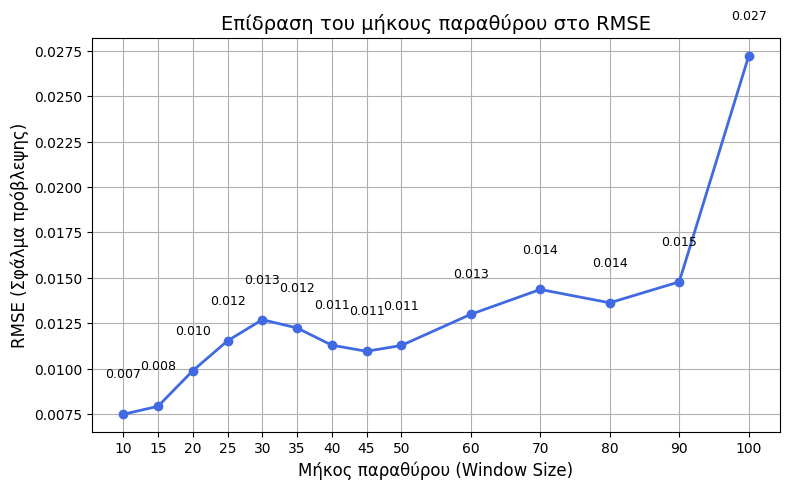

In [41]:
# Δημιουργία του γραφήματος
plt.figure(figsize=(8, 5))
plt.plot(windows, rmses, marker='o', linestyle='-', linewidth=2, color='royalblue')

# Τίτλος και άξονες
plt.title("Επίδραση του μήκους παραθύρου στο RMSE", fontsize=14)
plt.xlabel("Μήκος παραθύρου (Window Size)", fontsize=12)
plt.ylabel("RMSE (Σφάλμα πρόβλεψης)", fontsize=12)

# Εμφάνιση τιμών RMSE πάνω από κάθε σημείο
for i, rmse in enumerate(rmses):
    plt.text(windows[i], rmse + 0.002, f"{rmse:.3f}", ha='center', fontsize=9)

# Στυλ και μορφοποίηση
plt.grid(True)
plt.xticks(windows)
plt.tight_layout()
plt.show()

## Παράγει training δεδομένα για ένα μοντέλο (π.χ. ESN) που προβλέπει τις επόμενες 10 τιμές της χρονοσειράς x, χρησιμοποιώντας τις προηγούμενες 50.

In [71]:
y_targets = list()
X_ins = list()
prices = list()

# Παράμετροι
input_window = 10
forecast_horizon = 10

for i in range(len(df)):
    end = i + input_window + forecast_horizon
    if end > len(df):
        break  # Αν δεν έχουμε αρκετά δεδομένα για full παράθυρο

    # Ολόκληρο το παράθυρο: input + forecast
    seq_full = df['x'].iloc[i:end].reset_index(drop=True)

    # Είσοδος: οι πρώτες 50 τιμές
    seq_input = seq_full[:input_window]
    X_ins.append(np.round(np.array(seq_input), 5))

    # Στόχος: οι επόμενες 10 τιμές
    seq_target = seq_full[input_window:]  # δηλαδή θέσεις 50–59
    y_targets.append(np.round(np.array(seq_target), 5))

    # Για normalization (προαιρετικά)
    prices.append(seq_input.iloc[-1])

X = np.array(X_ins)           # shape = (n_samples, 50)
Y = np.array(y_targets)       # shape = (n_samples, 10)

## Διαχωρισμός train/test set για χρονοσειρά

In [72]:
# Διαχωρισμός σε 80% train / 20% test
ts = round(len(X) * 0.8)

train_set = X[:ts]
test_set = X[ts:]

y_train = Y[:ts]
y_test = Y[ts:]

# Προσθέτουμε και τον διαχωρισμό για prices (τελευταία τιμή εισόδου κάθε δείγματος)
prev_train = prices[:ts]
prev_test = prices[ts:]


# Train set

## Εκπαίδευση του ESN στο training set και πρόβλεψη πάνω στο ίδιο σετ, ώστε να δεις πώς συμπεριφέρεται το μοντέλο στα ίδια δεδομένα με τα οποία εκπαιδεύτηκε (training performance).

In [73]:
# Εκπαίδευση (fit) του ESN στο training set
#   - Το ESN «μαθαίνει» τον γραμμικό read-out (Ridge) βασιζόμενο στις καταστάσεις του reservoir
#   - Χρησιμοποιεί train_set (X) και y_train (στόχους) για να υπολογίσει τα κατάλληλα βάρη
esn.fit(train_set, y_train)

# Πρόβλεψη (predict) του ίδιου training set
#   - Μετά την εκπαίδευση, παράγει τις τιμές που «πιστεύει» ότι αντιστοιχούν στα train_set
#   - Αποθηκεύουμε το αποτέλεσμα σε predictions_train
predictions_train = esn.predict(train_set)

In [74]:
ts = round(len(X)*0.8)
#inputs
train_set = X[:ts]
test_set = X[ts:]
#outputs
y_train = y_targets[:ts]
y_test = y_targets[ts:]

y_train = np.array(y_train)
y_test = np.array(y_test)

In [75]:
# Εκπαίδευση (fit) του ESN στο training set
#   - Το ESN «μαθαίνει» τον γραμμικό read-out (Ridge) βασιζόμενο στις καταστάσεις του reservoir
#   - Χρησιμοποιεί train_set (X) και y_train (στόχους) για να υπολογίσει τα κατάλληλα βάρη
esn.fit(train_set, y_train)

# Πρόβλεψη (predict) του ίδιου training set
#   - Μετά την εκπαίδευση, παράγει τις τιμές που «πιστεύει» ότι αντιστοιχούν στα train_set
#   - Αποθηκεύουμε το αποτέλεσμα σε predictions_train
predictions_train = esn.predict(train_set)


## Οπτικοποιεί τη multi-step πρόβλεψη του μοντέλου για ένα συγκεκριμένο δείγμα εισόδου. Σχεδιάζει τόσο τις προβλέψεις όσο και τις πραγματικές τιμές για τα επόμενα 10 βήματα (t+1 έως t+10).




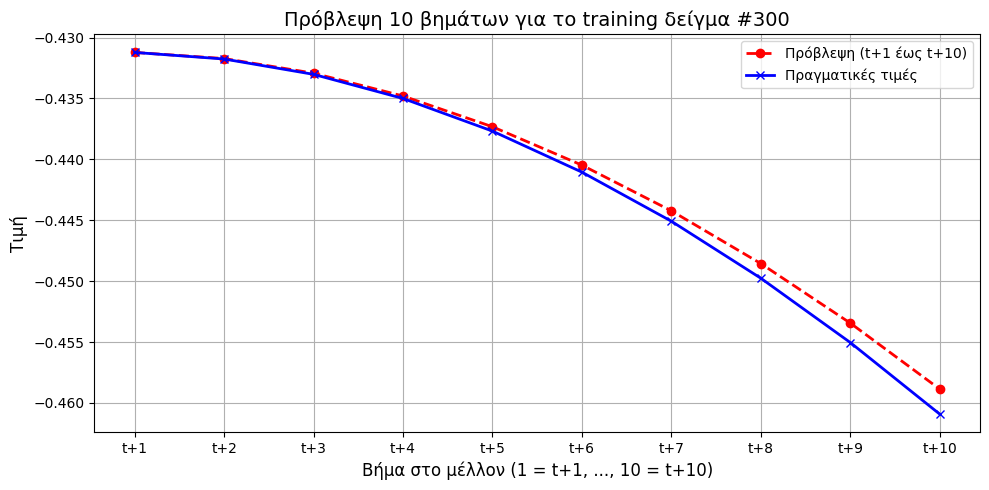

In [78]:
# Επίλεξε το δείγμα που θέλεις να προβάλλεις (π.χ. δείγμα #10)
sample_index = 300

# Δημιουργία του διαγράμματος
plt.figure(figsize=(10, 5))

# Προβλέψεις για t+1 έως t+10
plt.plot(
    predictions_train[sample_index],
    label='Πρόβλεψη (t+1 έως t+10)',
    linestyle='--',
    marker='o',
    linewidth=2,
    color='red'
)

# Πραγματικές τιμές για t+1 έως t+10
plt.plot(
    y_train[sample_index],
    label='Πραγματικές τιμές',
    linestyle='-',
    marker='x',
    linewidth=2,
    color='blue'
)

# Επεξηγήσεις και styling
plt.title(f'Πρόβλεψη 10 βημάτων για το training δείγμα #{sample_index}', fontsize=14)
plt.xlabel('Βήμα στο μέλλον (1 = t+1, ..., 10 = t+10)', fontsize=12)
plt.ylabel('Τιμή', fontsize=12)
plt.xticks(ticks=range(10), labels=[f't+{i+1}' for i in range(10)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Αυτή η διαδικασία υπολογίζει πόσες φορές το ESN “έπιασε” σωστά την τάση (πάνω ή κάτω) της τιμής σε σχέση με την προηγούμενη τιμή του παραθύρου στο Training set :
## Αυτό το μπλοκ υπολογίζει το directional accuracy ανά χρονικό βήμα πρόβλεψης (t+1, t+2, ..., t+10) για multi-step forecasting με ESN 

In [79]:


# Πίνακας για αποθήκευση accuracy ανά βήμα
directional_accuracies = []

# Πόσα forecast steps έχεις (π.χ. 10)
forecast_horizon = y_train.shape[1]  # = 10

for step in range(forecast_horizon):
    correct = 0
    total = len(y_train)

    for i in range(total):
        real = y_train[i, step]               # Πραγματική τιμή για το step
        pred = predictions_train[i, step]     # Πρόβλεψη για το ίδιο step
        prev_val = prices[i]                  # Τελευταία τιμή εισόδου

        # Έλεγχος κατεύθυνσης
        if real > prev_val and pred > prev_val:
            correct += 1
        elif real < prev_val and pred < prev_val:
            correct += 1

    # Υπολογισμός ποσοστού επιτυχίας για αυτό το βήμα
    acc = correct / total
    directional_accuracies.append(acc)

# Εμφάνιση αποτελεσμάτων
for i, acc in enumerate(directional_accuracies):
    print(f"Directional accuracy στο t+{i+1}: {acc:.3f}")


Directional accuracy στο t+1: 0.998
Directional accuracy στο t+2: 0.998
Directional accuracy στο t+3: 0.998
Directional accuracy στο t+4: 0.997
Directional accuracy στο t+5: 0.996
Directional accuracy στο t+6: 0.996
Directional accuracy στο t+7: 0.995
Directional accuracy στο t+8: 0.993
Directional accuracy στο t+9: 0.990
Directional accuracy στο t+10: 0.990


## Απόκλιση πραγματικής απο προβλεπόμενη τιμή για κάθε βήμα χρόνου στο train set

In [80]:
mae_train = []
forecast_horizon = y_train.shape[1]

for step in range(forecast_horizon):
    error = np.abs(predictions_train[:, step] - y_train[:, step])
    mae = np.mean(error)
    mae_train.append(mae)

# Εμφάνιση
for i, err in enumerate(mae_train):
    print(f"MAE στο t+{i+1}: {err:.4f}")


MAE στο t+1: 0.0001
MAE στο t+2: 0.0002
MAE στο t+3: 0.0003
MAE στο t+4: 0.0006
MAE στο t+5: 0.0012
MAE στο t+6: 0.0020
MAE στο t+7: 0.0032
MAE στο t+8: 0.0050
MAE στο t+9: 0.0072
MAE στο t+10: 0.0101


## Ποσοστιαία Απόκλιση (MAPE) στο train_set

In [81]:
mape_train = []

for step in range(forecast_horizon):
    actuals = y_train[:, step]
    preds   = predictions_train[:, step]

    # Μάσκα για να αποφύγεις διαίρεση με 0
    non_zero_mask = actuals != 0

    percent_errors = np.abs((preds[non_zero_mask] - actuals[non_zero_mask]) / actuals[non_zero_mask]) * 100
    mape = np.mean(percent_errors)
    mape_train.append(mape)

# Εμφάνιση
for i, err in enumerate(mape_train):
    print(f"MAPE στο t+{i+1}: {err:.2f}%")


MAPE στο t+1: 0.08%
MAPE στο t+2: 0.13%
MAPE στο t+3: 0.25%
MAPE στο t+4: 0.49%
MAPE στο t+5: 0.94%
MAPE στο t+6: 1.70%
MAPE στο t+7: 2.73%
MAPE στο t+8: 4.05%
MAPE στο t+9: 6.01%
MAPE στο t+10: 8.30%


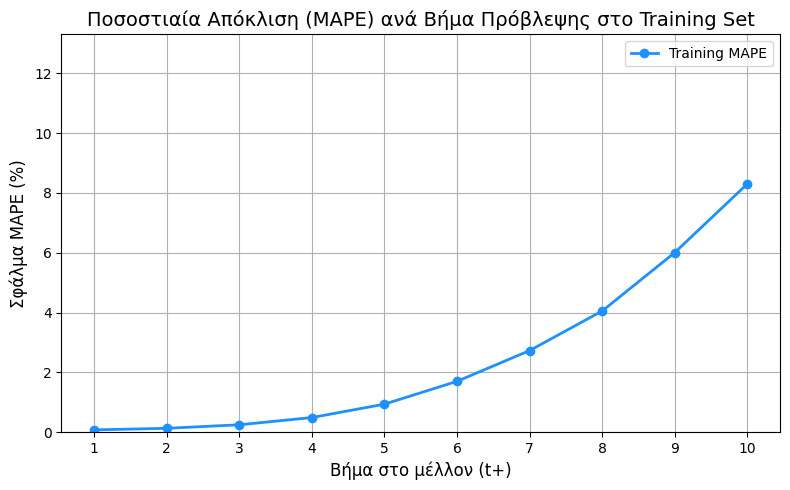

In [82]:
plt.figure(figsize=(8, 5))

# Καμπύλη MAPE ανά βήμα (t+1 έως t+10)
plt.plot(
    range(1, forecast_horizon + 1),   # x: τα βήματα
    mape_train,                       # y: MAPE ανά βήμα
    marker='o',
    linewidth=2,
    linestyle='-',
    color='dodgerblue',
    label='Training MAPE'
)

# Στυλ και επεξηγήσεις
plt.title("Ποσοστιαία Απόκλιση (MAPE) ανά Βήμα Πρόβλεψης στο Training Set", fontsize=14)
plt.xlabel("Βήμα στο μέλλον (t+)", fontsize=12)
plt.ylabel("Σφάλμα MAPE (%)", fontsize=12)
plt.ylim(0, max(mape_train) + 5)
plt.grid(True)
plt.xticks(ticks=range(1, forecast_horizon + 1))
plt.legend()
plt.tight_layout()
plt.show()


### Βλέπουμε ότι όσο πιο μακριά προσπαθούμε να προβλέψουμε στον χρόνο το σφάλμα μεγαλώνει

# Test set

# esn.predict(test_set): χρησιμοποιεί το ήδη “εκπαιδευμένο” μοντέλο (esn.fit έχει ήδη τρέξει) ώστε να εκτιμήσει τις επόμενες τιμές για κάθε παράθυρο στο test_set.

## Το ESN σου παράγει προβλέψεις multi-step (π.χ. 10 βημάτων) πάνω στο test set, δηλαδή σε δεδομένα που δεν έχει δει ποτέ κατά την εκπαίδευση. Αυτή είναι και η πιο κρίσιμη στιγμή για να αξιολογήσεις:
### Πόσο καλά γενικεύει το μοντέλο σου
### Αν πραγματικά "έμαθε" το πρόβλημα ή απλώς έμαθε το training set

In [83]:
# Παράγουμε τις προβλέψεις του ESN για τα νέα, αθέατα δεδομένα του test set
predictions_test = esn.predict(test_set)

## Οπτικοποιεί τη multi-step πρόβλεψη του μοντέλου για ένα συγκεκριμένο δείγμα εισόδου. Σχεδιάζει τόσο τις προβλέψεις όσο και τις πραγματικές τιμές για τα επόμενα 10 βήματα (t+1 έως t+10).
### Τις προβλέψεις του ESN για τα επόμενα 10 βήματα (σε κόκκινο
### Τις πραγματικές τιμές (σε μπλε)
### Για ένα συγκεκριμένο δείγμα του test set (sample_index = 80)



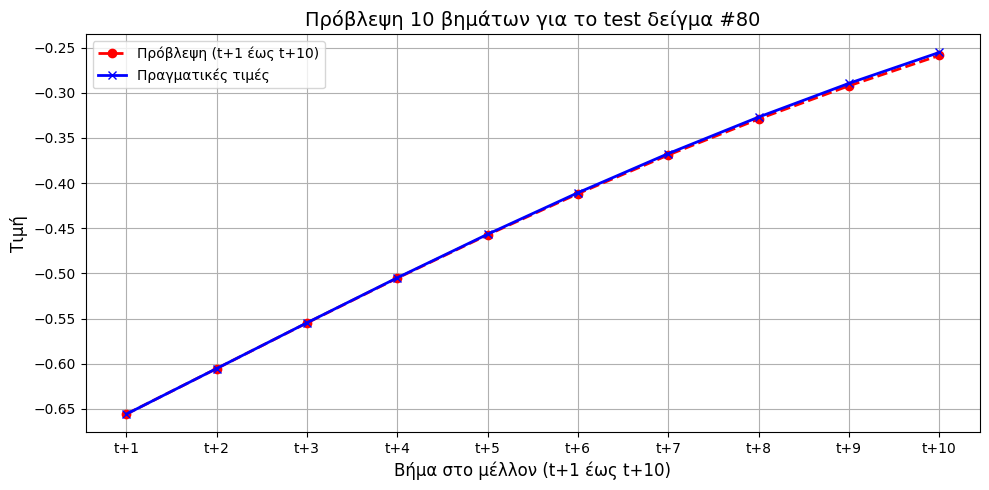

In [90]:


# Διάλεξε δείγμα από το test set (π.χ. το 10ο δείγμα μέσα στο test set)
sample_index = 80

# Δημιουργία γραφήματος
plt.figure(figsize=(10, 5))

# Προβλέψεις (10 βήματα στο μέλλον)
plt.plot(
    predictions_test[sample_index],
    label='Πρόβλεψη (t+1 έως t+10)',
    linestyle='--',
    marker='o',
    linewidth=2,
    color='red'
)

# Πραγματικές τιμές (ground truth)
plt.plot(
    y_test[sample_index],
    label='Πραγματικές τιμές',
    linestyle='-',
    marker='x',
    linewidth=2,
    color='blue'
)

# Διαμόρφωση και επεξηγήσεις
plt.title(f'Πρόβλεψη 10 βημάτων για το test δείγμα #{sample_index}', fontsize=14)
plt.xlabel('Βήμα στο μέλλον (t+1 έως t+10)', fontsize=12)
plt.ylabel('Τιμή', fontsize=12)
plt.xticks(ticks=range(10), labels=[f't+{i+1}' for i in range(10)])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Αυτό το κομμάτι κώδικα υπολογίζει την «κατευθυντική ακρίβεια» (directional accuracy) του μοντέλου στο test set, δηλαδή το ποσοστό των φορών που μάντεψε σωστά αν η τιμή θα κινηθεί πάνω ή κάτω σε σχέση με την προηγούμενη τιμή.

In [91]:
# Υπολογισμός directional accuracy για κάθε βήμα στο μέλλον (t+1 έως t+10) στο test set

forecast_horizon = y_test.shape[1]  # π.χ. 10
directional_accuracies_test = []

for step in range(forecast_horizon):
    correct = 0
    total = len(y_test)

    for i in range(total):
        real = y_test[i, step]              # Πραγματική τιμή για το βήμα αυτό
        pred = predictions_test[i, step]    # Πρόβλεψη για το ίδιο βήμα
        prev_val = prev_test[i]             # Τελευταία τιμή εισόδου για το δείγμα

        if real > prev_val and pred > prev_val:
            correct += 1
        elif real < prev_val and pred < prev_val:
            correct += 1

    acc = correct / total
    directional_accuracies_test.append(acc)

# Εκτύπωση αποτελεσμάτων ανά forecast βήμα
for i, acc in enumerate(directional_accuracies_test):
    print(f"Test set - Directional accuracy στο t+{i+1}: {acc:.3f}")


Test set - Directional accuracy στο t+1: 0.972
Test set - Directional accuracy στο t+2: 0.973
Test set - Directional accuracy στο t+3: 0.972
Test set - Directional accuracy στο t+4: 0.972
Test set - Directional accuracy στο t+5: 0.972
Test set - Directional accuracy στο t+6: 0.973
Test set - Directional accuracy στο t+7: 0.972
Test set - Directional accuracy στο t+8: 0.973
Test set - Directional accuracy στο t+9: 0.971
Test set - Directional accuracy στο t+10: 0.973


## Απόκλιση πραγματικής απο προβλεπόμενη τιμή για κάθε βήμα χρόνου στο test set

In [92]:


# Πίνακας αποκλίσεων ανά βήμα
stepwise_errors = []

# Ορίζουμε τον χρονικό ορίζοντα
forecast_horizon = y_test.shape[1]

# Για κάθε χρονικό βήμα
for step in range(forecast_horizon):
    # Απόλυτες αποκλίσεις για όλα τα δείγματα στο συγκεκριμένο βήμα
    step_errors = np.abs(predictions_test[:, step] - y_test[:, step])
    
    # Μέση απόκλιση στο συγκεκριμένο βήμα (MAE)
    mean_error = np.mean(step_errors)
    stepwise_errors.append(mean_error)

# Εμφάνιση ανά βήμα
for i, err in enumerate(stepwise_errors):
    print(f"Μέση απόκλιση στο t+{i+1}: {err:.4f}")


Μέση απόκλιση στο t+1: 0.0070
Μέση απόκλιση στο t+2: 0.0096
Μέση απόκλιση στο t+3: 0.0139
Μέση απόκλιση στο t+4: 0.0210
Μέση απόκλιση στο t+5: 0.0322
Μέση απόκλιση στο t+6: 0.0489
Μέση απόκλιση στο t+7: 0.0723
Μέση απόκλιση στο t+8: 0.1030
Μέση απόκλιση στο t+9: 0.1410
Μέση απόκλιση στο t+10: 0.1860


## Ποσοστιαία απόκλιση Πραγματικής με Προβλεπόμενη τιμη

In [93]:
stepwise_mape = []
forecast_horizon = y_test.shape[1]

for step in range(forecast_horizon):
    actuals = y_test[:, step]
    preds   = predictions_test[:, step]

    # Μάσκα για να αγνοήσουμε μηδενικές πραγματικές τιμές
    non_zero_mask = actuals != 0

    # Υπολογισμός ποσοστιαίου σφάλματος μόνο όπου y ≠ 0
    percent_errors = np.abs((preds[non_zero_mask] - actuals[non_zero_mask]) / actuals[non_zero_mask]) * 100
    mape = np.mean(percent_errors)

    stepwise_mape.append(mape)

# Εμφάνιση αποτελεσμάτων
for i, err in enumerate(stepwise_mape):
    print(f"MAPE στο t+{i+1}: {err:.2f}%")


MAPE στο t+1: 2.17%
MAPE στο t+2: 3.17%
MAPE στο t+3: 4.94%
MAPE στο t+4: 8.05%
MAPE στο t+5: 13.24%
MAPE στο t+6: 21.35%
MAPE στο t+7: 33.19%
MAPE στο t+8: 49.71%
MAPE στο t+9: 71.50%
MAPE στο t+10: 99.50%


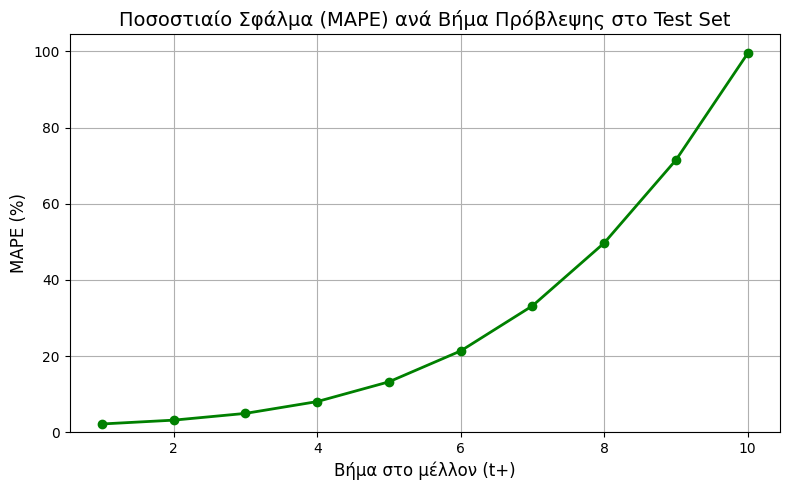

In [94]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, forecast_horizon+1), stepwise_mape, marker='o', linewidth=2, color='green')
plt.title("Ποσοστιαίο Σφάλμα (MAPE) ανά Βήμα Πρόβλεψης στο Test Set", fontsize=14)
plt.xlabel("Βήμα στο μέλλον (t+)", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.ylim(0, max(stepwise_mape) + 5)
plt.grid(True)
plt.tight_layout()
plt.show()


## Προφανώς παρατηρούμε ότι όσο πιο μακροπρόθεσμα προσπαθούμε να προβλέψουμε το σφάλμα αυξάνει